# Scripts for CPlantBox

 [CPlantBox](https://github.com/Plant-Root-Soil-Interactions-Modelling/CPlantBox) is a functional structural plant model based on CRootBox. It is currently underconstruction. But some of the functions are already working.Serveral ways to use the CPlantBox are:
 

 1. Python Scripts.
 2. Directly compiling and running the C++ source file.
 3. Precompiled programm for windows.
 4. Online application.

Among them the the python scripting is the recommended and most robust way. In the first part of the toturial, you could create a 3D visualized plant like this [click Here (a visualized CPlantBox output)](http://xrzhou.com/content/vtkjs/GeometryViewer/GeometryViewer.html?fileURL=http://xrzhou.com/content/1-projects/leaf.vtp).

In this notebook, we can see how the CPlantBox is working and how to play around with it. Tutorial part is similar to CRootBox tutorial written by [Daniel Leitner](http://www.simwerk.at/contact/). R code part are mainly written by [Guillaume Lobet](http://www.guillaumelobet.be/).

## 1.Read parameter file and generate a simple output

In line7, we could change the parameter name inside the qoutation marks, if we want to use different parameter. Normally we use the XML based parameter file. If you are using a .rparam file frome the CRootBox, you can directly use them here, but after the first run the new Parameter file is generated, and you can further use the new file later on.

In [1]:
import py_plantbox as pb # Open  and root parameter from a file
from rb_tools import *

plant = pb.Plant()

# Open  and root parameter from a file
name = "CPlantBox_test_leaf_tree" # you can change it to the name of other XML parameter files for example""
plant.openXML(name)

# Initialize
plant.initialize()


for dt in range (0,30):
    plant.simulate(dt)
    

# Simulate
#plant.simulate(60, True)

# Export final result (as vtp)
#2 = root
#4 = stem
#8 = leaf
#15 = all
analysis = pb.SegmentAnalyser(plant) 
analysis.write("results/test.vtp") #to generate the .vtp file
analysis.write("results/test.txt") #to generate the matlab file



## 1.1 Creating a constrained plant inside a Box

In [3]:
import py_plantbox as pb
plant = pb.Plant()

# Open plant and root parameter from a file
name = "Anagallis_femina_Leitner_2010" 
plant.openFile(name)

# Create and set geometry

# 1.creates a cylindrical soil core with top radius 5 cm, bot radius 5 cm, height 50 cm, not square but circular
soilcore = pb.SDF_PlantContainer(5,5,40,False)

# 2. creates a square 27*27 cm containter with height 1.4 cm 
rhizotron = pb.SDF_PlantBox(1.4,27,27)

# Pick 1, or 2
plant.setGeometry(soilcore)  # soilcore, or rhizotron

# Initialize
plant.initialize() 

# Simulate
plant.simulate(60) # days

# Export final result (as vtp)
plant.write("results/example_1b.vtp",15)  

# Export container geometry as Paraview Python script
plant.write("results/example_1b.py",15) 

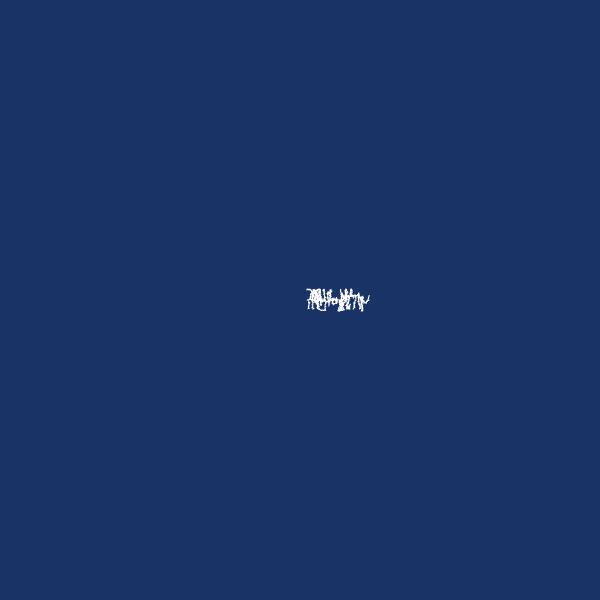

In [3]:
import vtk
from vtk import *
from IPython.display import Image

reader = vtk.vtkXMLPolyDataReader()
path = "results/example_1b.vtp" #path or name of the vtp output
reader.SetFileName(path)
reader.Update()
 
mapper = vtk.vtkPolyDataMapper()
mapper.SetInputData(reader.GetOutput())
 
plantActor = vtk.vtkActor()
plantActor.SetMapper( mapper )

camera =vtkCamera()
camera.SetPosition(500, 10, 0)
camera.SetFocalPoint(0, 0, 0)   

ren1= vtk.vtkRenderer()
ren1.AddActor( plantActor )
ren1.SetActiveCamera(camera)
ren1.SetBackground( 0.1, 0.2, 0.4 )


renWin = vtk.vtkRenderWindow()
renWin.AddRenderer( ren1 )
renWin.SetSize( 600, 600 )


iren = vtk.vtkRenderWindowInteractor()
iren.SetRenderWindow(renWin)
    
renWin.Render()

windowToImageFilter = vtkWindowToImageFilter()
windowToImageFilter.SetInput(renWin)
windowToImageFilter.Update()


writer = vtkPNGWriter()
writer.SetWriteToMemory(1)
writer.SetInputConnection(windowToImageFilter.GetOutputPort())
writer.Write()
data = bytearray(memoryview(writer.GetResult()))

Image(data)

10


## 1.2 Creating one Maize Roots in rhizotube field

In [2]:
import py_plantbox as pb
import math

plant = pb.Plant()

# Open plant and root parameter from a file
name = "Zea_mays_4_Leitner_2014"
plant.openFile(name)

# 1. Creates a square rhizotron r*r, with height h, rotated around the x-axis 
r, h, alpha = 20, 4, 45
rhizotron2 = pb.SDF_PlantContainer(r,r,h,True)
posA = pb.Vector3d(0,r,-h/2) # origin before rotation
A = pb.Matrix3d.rotX(alpha/180.*math.pi)
posA = A.times(posA) # origin after rotation
rotatedRhizotron = pb.SDF_RotateTranslate(rhizotron2,alpha,0,posA.times(-1))

# 2. A split pot experiment
topBox = pb.SDF_PlantBox(22,20,5)
sideBox = pb.SDF_PlantBox(10,20,35)
left = pb.SDF_RotateTranslate(sideBox, pb.Vector3d(-6,0,-5))
right = pb.SDF_RotateTranslate(sideBox, pb.Vector3d(6,0,-5))
box_ = pb.std_vector_SDF_()
box_.append(topBox)
box_.append(left)
box_.append(right)
splitBox = pb.SDF_Union(box_)

# 3. Rhizotubes as obstacles 
box = pb.SDF_PlantBox(96,126,130) # box
rhizotube = pb.SDF_PlantContainer(6.4,6.4,96,False) # a single rhizotube
rhizoX = pb.SDF_RotateTranslate(rhizotube, 90, pb.SDF_Axis.yaxis, pb.Vector3d(96/2,0,0))

rhizotubes_ = pb.std_vector_SDF_()
y_ = ( -30, -18, -6, 6, 18, 30 )
z_ = ( -10, -20, -40, -60, -80, -120 )
tube = [] 
for i in range(0,len(y_)):
    v = pb.Vector3d(0,y_[i],z_[i])
    tube.append(pb.SDF_RotateTranslate(rhizoX, v))
    rhizotubes_.append(tube[i])    
    
rhizotubes = pb.SDF_Union(rhizotubes_)
rhizoTube = pb.SDF_Difference(box, rhizotubes)

# Set geometry: rotatedRhizotron, splitBox, or rhizoTube
plant.setGeometry(rhizoTube)  

# Simulate
plant.initialize() 
plant.simulate(90) # days   

# Export results (as vtp)    
plant.write("results/example_2a.vtp",15)

# Export container geometry as Paraview Python script 
plant.write("results/example_2a.py",15)



## 1.2 Creating 9 Maize Roots in normal field
change one element arrtibute value in the parameter file based on its name

In [1]:
import py_plantbox as pb
import xml.etree.ElementTree as ET



plant = pb.Plant()
allplant = pb.Plant()
allana = pb.SegmentAnalyser(allplant)
#seed = pb.Seed()
#plant = pb.Plant()
param = pb.SeedTypeParameter()
#print(param.seedPos)
name = "CPlantBox_test_leaf_tree"
simtime = 30
row = 3 # number of columns and rows
column = 3
dist = 40 # distance between the root systems [cm]

# Initializes N*N root systems
paraname = [[0 for x in range(row)] for y in range(column)] 
paraname[0][0] = name
tree = ET.parse("modelparameter\\"+paraname[0][0]+".xml")
for i in range(0,row):
    for j in range(0,column):

        root = tree.getroot()
        seedx=root.find(".//*[@name='seedPos.x']")
        seedy=root.find(".//*[@name='seedPos.y']")
        seedx.set('value',str(dist*i))
        seedy.set('value',str(dist*j))
        a=root.find(".//*[@name='seedPos.x']").attrib.get('value')
        #print(a)
        paraname[i][j]=name+str(i)+str(j)
        tree.write('modelparameter\\'+paraname[i][j]+'.xml')
        #print(paraname[i][j])
        plant.openXML(str(paraname[i][j]))
        plant.initialize()    
        plant.simulate(simtime, True)
        vtpname = 'results\\'+name+str(i)+str(j)+'.vtp'
        ana = pb.SegmentAnalyser(plant) 
        ana.write(vtpname)
        allana.addSegments(plant) # collect all
        # Export results as single vtp files (as polylines)
allana.write("results/example_2b_all.vtp") 
    
      


      
# Write all into single file (segments)

       

In [4]:
########## under construction ##############

import py_plantbox as pb
from rb_tools import *
import numpy as np
import matplotlib.pyplot as plt

plant = pb.Plant()
name = "Brassica_oleracea_Vansteenkiste_2014" 
plant.openXML(name)
plant.initialize() 

simtime = 60. # days
dt = 1.
N = round(simtime/dt) # steps
 
# Plot some scalar value over time
stype = pb.ScalarType.length 
stype_str = "length (cm)"
v_ = np.zeros(N)
v1_ = np.zeros(N)
v2_ = np.zeros(N)
v3_ = np.zeros(N)
for i in range(0,N):
    plant.simulate(dt,True)
    t = v2a(plant.getScalar("subtype"))
    v = v2a(plant.getScalar(stype))
    v_[i] = np.sum(v)
    v1_[i] = np.sum(v[t==1])  
    v2_[i] = np.sum(v[t==2]) 
    v3_[i] = np.sum(v[t==3]) 
        
t_ = np.linspace(dt, N*dt, N)
plt.plot(t_,v_)
plt.plot(t_,v1_)
plt.plot(t_,v2_)
plt.plot(t_,v3_)
plt.xlabel("time (days)")
plt.ylabel(stype_str)
plt.legend(["total", "tap root", "lateral", "2. order lateral"])
plt.savefig("results/example_3a.png")
plt.show()

# Find root tips and bases (two approaches)
plant.initialize() 
plant.simulate(7, True) # 7 days young....

print(plant.getNumberOfNodes(), "nodes")
print(plant.getNumberOfSegments(), "segments")

# Use polyline representation of the roots
polylines = plant.getPolylines()    
# bases = np.zeros((len(polylines),3))
tips = np.zeros((len(polylines),3))
for i,r in enumerate(polylines):
    bases[i,:] = [r[0].x,r[0].y,r[0].z]
    tips[i,:] = [r[-1].x,r[-1].y,r[-1].z]

# Or, use node indices to find tip or base nodes
nodes = vv2a(plant.getNodes())
tipI = plant.getRootTips()
baseI = plant.getRootBases()

# Plot results (1st approach)
plt.title("Top view")
plt.xlabel("cm")
plt.ylabel("cm")
plt.scatter(nodes[baseI,0], nodes[baseI,1], c="g", label = "root bases")
plt.scatter(nodes[tipI,0], nodes[tipI,1], c="r", label = "root tips")
plt.savefig("results/example_3a2.png")
plt.show()

 # check if the two approaches yield the same result
uneq = np.sum(nodes[baseI,:]!=bases) + np.sum(nodes[tipI,:]!=tips)
print("Unequal tips and basals:", uneq)



ArgumentError: Python argument types in
    Plant.getScalar(Plant, str)
did not match C++ signature:
    getScalar(class Plant {lvalue}, unsigned int, class std::basic_string<char,struct std::char_traits<char>,class std::allocator<char> >)

## 2. Data analysis using R
In the following blocks of section 2, R is used as programming language for data analysis and visualiztion. First we use _warnings_ and _rpy2_ package in python.

In [2]:
# Hide warnings if there are any
import warnings
import rpy2.ipython
warnings.filterwarnings('ignore')
# Load in the r magic package
%load_ext rpy2.ipython
# We need ggplot2


### 2.1 Visualiztion of different organ length

In [3]:

%%R 
library(plyr)
library(tidyverse)

 rs <- read_delim("results/test.txt",  delim = " ") %>%
  mutate(time = round(time)) %>%
  mutate(length = sqrt((x2-x1)^2 + (y2-y1)^2 + (z2-z1)^2))

 rs2 <- ddply(rs, .(type, organ, time), summarise, length=sum(length)) %>%
   filter(time > 0)



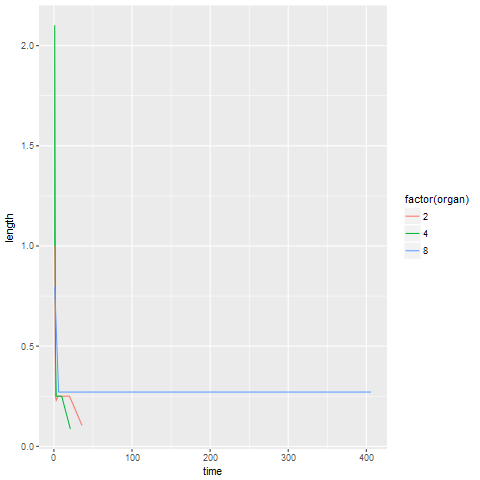

TypeError: 'rpy2.rinterface.RNULLType' object is not iterable

R object with classes: ('list',) mapped to:
<ListVector - Python:0x000002D782C8AC08 / R:0x000002D78736C3E0>
[ListVector, Environment, ListVector]
R object with classes: ('list',) mapped to:
<ListVector - Python:0x000002D782C8AC08 / R:0x000002D78736C3E0>
[ListVector, Environment, ListVector]
  layout: <class 'rpy2.robjects.environments.Environment'>
  R object with classes: ('Layout', 'ggproto') mapped to:
<Environment - Python:0x000002D782B38448 / R:0x000002D783FCFAB0>
R object with classes: ('list',) mapped to:
<ListVector - Python:0x000002D782C8AC08 / R:0x000002D78736C3E0>
[ListVector, Environment, ListVector]

In [4]:
%R print(ggplot(rs2, aes(time, length, colour=factor(organ))) +    geom_line())

## 4. "screenshot" of the 3D architecture
In this paragraph, we can could use a 2D "screenshot" to show the output. There are 3 ways to do it. In this notebook, we can use 2 ways which are
1. using R and gganimate to generate the animation
2. using VTK package 

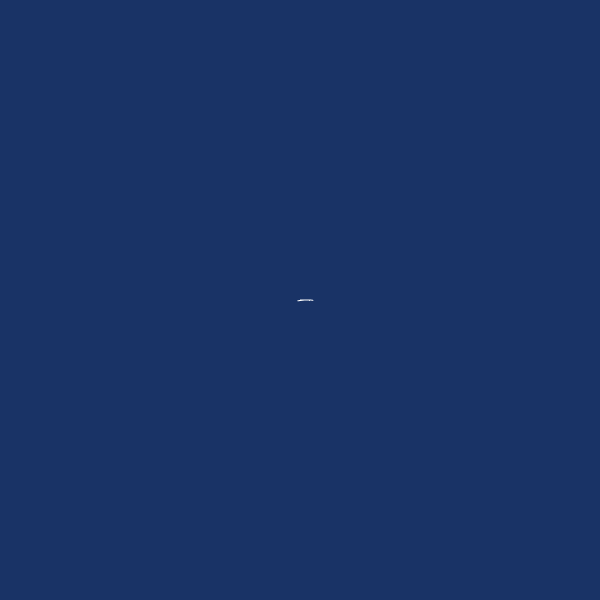

In [5]:
import vtk
from vtk import *
from IPython.display import Image

reader = vtk.vtkXMLPolyDataReader()
path = "results/test.vtp" #path or name of the vtp output
reader.SetFileName(path)
reader.Update()
 
mapper = vtk.vtkPolyDataMapper()
mapper.SetInputData(reader.GetOutput())
 
plantActor = vtk.vtkActor()
plantActor.SetMapper( mapper )

camera =vtkCamera()
camera.SetPosition(500, 10, 0)
camera.SetFocalPoint(0, 0, 0)   

ren1= vtk.vtkRenderer()
ren1.AddActor( plantActor )
ren1.SetActiveCamera(camera)
ren1.SetBackground( 0.1, 0.2, 0.4 )


renWin = vtk.vtkRenderWindow()
renWin.AddRenderer( ren1 )
renWin.SetSize( 600, 600 )


iren = vtk.vtkRenderWindowInteractor()
iren.SetRenderWindow(renWin)
    
renWin.Render()

windowToImageFilter = vtkWindowToImageFilter()
windowToImageFilter.SetInput(renWin)
windowToImageFilter.Update()


writer = vtkPNGWriter()
writer.SetWriteToMemory(1)
writer.SetInputConnection(windowToImageFilter.GetOutputPort())
writer.Write()
data = bytearray(memoryview(writer.GetResult()))

Image(data)

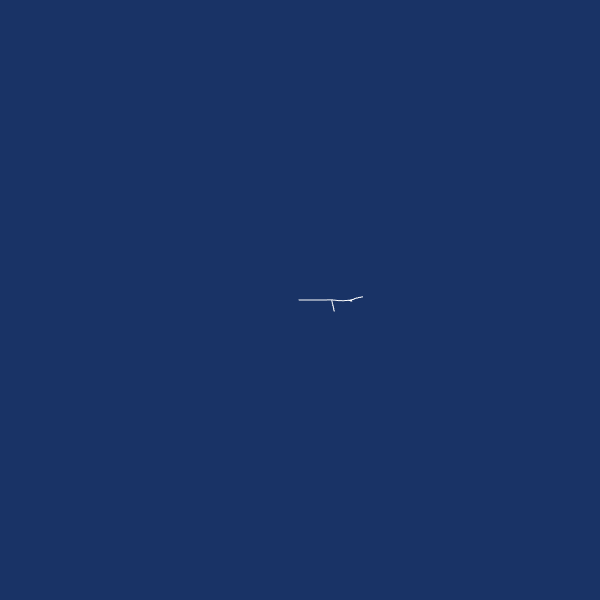

In [7]:
import vtk
from vtk import *
from IPython.display import Image

reader = vtk.vtkXMLPolyDataReader()
path = "results/example_5a.vtp" #path or name of the vtp output
reader.SetFileName(path)
reader.Update()
 
mapper = vtk.vtkPolyDataMapper()
mapper.SetInputData(reader.GetOutput())
 
plantActor = vtk.vtkActor()
plantActor.SetMapper( mapper )

camera =vtkCamera()
camera.SetPosition(100, 100, 0)
camera.SetFocalPoint(0, 0, 0)   

ren1= vtk.vtkRenderer()
ren1.AddActor( plantActor )
ren1.SetActiveCamera(camera)
ren1.SetBackground( 0.1, 0.2, 0.4 )


renWin = vtk.vtkRenderWindow()
renWin.AddRenderer( ren1 )
renWin.SetSize( 600, 600 )

 

iren = vtk.vtkRenderWindowInteractor()
iren.SetRenderWindow(renWin)
    

renWin.Render()


windowToImageFilter = vtkWindowToImageFilter()
windowToImageFilter.SetInput(renWin)
windowToImageFilter.Update()

 

writer = vtkPNGWriter()
writer.SetWriteToMemory(1)
writer.SetInputConnection(windowToImageFilter.GetOutputPort())
writer.Write()
data = bytearray(memoryview(writer.GetResult()))




Image(data)






True

In [18]:

from IPython.display import HTML
HTML('<iframe width="800" height="600" src="http://xrzhou.com/content/vtkjs/GeometryViewer/GeometryViewer.html?fileURL=http://xrzhou.com/content/1-projects/leaf.vtp" frameborder="0" allowfullscreen></iframe>')

## 4. Python binding with xylem water flux

In [3]:
import scipy.sparse.linalg as LA
from scipy import sparse
import matplotlib.pylab as plt

import py_plantbox as pb
from rb_tools import *

import xylem_flux 

import timeit


# Simulate a root system
name = "Phloem"
plant = pb.Plant()
plant.openXML(name)
plant.initialize()

for i in range (0,30):
    plant.simulate(i)
# for i in range(0,7):
#     plant.simulate(1) 

# Create graph
nodes = vv2a(plant.getNodes())/100 # convert from cm to m 
rseg = seg2a(plant.getSegments(2)) # root system segments
sseg = seg2a(plant.getSegments(4)) # root system segments
seg = np.vstack((sseg,rseg))
print("number of segments",len(seg))

# Adjacency matrix
A = sparse.coo_matrix((np.ones(seg.shape[0]),(seg[:,0],seg[:,1]))) 

# Parameters for flux model
rs_Kr = np.array([ 2.e-10, 2.e-10, 2.e-10, 2.e-10, 2.e-10, 2.e-11, 2.e-11 ]) # s/m; root hydraulic radial conductivity per root type 
rs_Kz = np.array([ 5.e-14, 5.e-14, 5.e-14, 5.e-14, 5e-14, 5e-14, 5e-14 ]) # m2*s; root hydraulic axial conductivity per root type 

soil_psi = -700 # static soil pressure J kg^-1

rho = 1e3 # kg / m^3      
g = 1.e-3*9.8065 # m / s^2   

pot_trans = np.array([-1.15741e-10]) # # m^3 s^-1 potential transpiration

# Conversions
plant_ana = pb.SegmentAnalyser(plant) 
radius = v2a(plant_ana.getScalar("radius"))/100. # convert from cm to m
type = v2a(plant_ana.getScalar("subtype"))
kr = np.array(list(map(lambda t: rs_Kr[int(t)-1], type))) # convert from 'per type' to 'per segment'
kr.resize((kr.shape[0],1))
kz = np.array(list(map(lambda t: rs_Kz[int(t)-1], type)))     
kz.resize((kz.shape[0],1))          

print(radius)
# glue together shoot and root segments
shoot1 = np.ones((sseg.shape[0],1))                    
shoot0 = np.ones((sseg.shape[0],1))
radius = np.vstack((shoot1,radius))
kr =  np.vstack((shoot0,kr))
kz =  np.vstack((shoot1,kz))  
            
# Call back function for soil potential
soil = lambda x,y,z : soil_psi

# Calculate fluxes within the root system
Q, b = xylem_flux.linear_system(seg, nodes, radius, kr, kz, rho, g, soil)
# plt.spy(Q)
# plt.show()
Q, b = xylem_flux.bc_neumann(Q, b, np.array([0]), np.array([pot_trans]))


start = timeit.default_timer()
x = LA.spsolve(Q, b, use_umfpack = True) # direct
stop = timeit.default_timer()
print ("linear system solved in", stop - start, " s") 
      
# Save results into vtp 
segP = nodes2seg(nodes,seg,x)# save vtp 
axial_flux = xylem_flux.axial_flux(x, seg, nodes, kz, rho, g)
radial_flux = xylem_flux.radial_flux(x, seg, nodes, radius, kr, soil)
net_flux = axial_flux+radial_flux

plant_ana.addUserData(a2v(segP[sseg.shape[0]:]),"pressure")
plant_ana.addUserData(a2v(axial_flux[sseg.shape[0]:]),"axial_flux")
plant_ana.addUserData(a2v(radial_flux[sseg.shape[0]:]),"radial_flux")
plant_ana.addUserData(a2v(net_flux[sseg.shape[0]:]),"net_flux")

plant_ana.write("results/example_5a.vtp")         


number of segments 436
[[0.00200588]
 [0.00200588]
 [0.00200588]
 [0.00200588]
 [0.00200588]
 [0.00200588]
 [0.00200588]
 [0.00200588]
 [0.00200588]
 [0.00200588]
 [0.00200588]
 [0.00200588]
 [0.00012169]
 [0.00012169]
 [0.00012169]
 [0.00012169]
 [0.00012169]
 [0.00012169]
 [0.00012169]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.00018514]
 [0.00018514]
 [0.00021066]
 [0.00021066]
 [0.00020322]
 [0.00020322]
 [0.00020312]
 [0.00020312]
 [0.00018556]
 [0.00018556]
 [0.0001823 ]
 [0.0001823

In [7]:
import scipy.sparse.linalg as LA
from scipy import sparse
import matplotlib.pylab as plt

import py_plantbox as pb
from rb_tools import *

import xylem_flux 

import timeit


# Simulate a root system
name = "Phloem"

plant = pb.Plant()
plant.openXML(name)
plant.initialize()
plant.simulate(dt)
# for i in range(0,7):
#     plant.simulate(1) 

# Create graph
nodes = vv2a(plant.getNodes())/100 # convert from cm to m 
rseg = seg2a(plant.getSegments(2)) # root system segments
sseg = seg2a(plant.getSegments(4)) # root system segments
seg = np.vstack((sseg,rseg))
print("number of segments",len(seg))

# Adjacency matrix
A = sparse.coo_matrix((np.ones(seg.shape[0]),(seg[:,0],seg[:,1]))) 

# Parameters for flux model
rs_Kr = np.array([ 2.e-10, 2.e-10, 2.e-10, 2.e-10, 2.e-10, 2.e-11, 2.e-11 ]) # s/m; root hydraulic radial conductivity per root type 
rs_Kz = np.array([ 5.e-14, 5.e-14, 5.e-14, 5.e-14, 5e-14, 5e-14, 5e-14 ]) # m2*s; root hydraulic axial conductivity per root type 

soil_psi = -700 # static soil pressure J kg^-1

rho = 1e3 # kg / m^3      
g = 1.e-3*9.8065 # m / s^2   

pot_trans = np.array([-1.15741e-10]) # # m^3 s^-1 potential transpiration

# Conversions
plant_ana = pb.SegmentAnalyser(plant) 
radius = v2a(plant_ana.getScalar("radius"))/100. # convert from cm to m
type = v2a(plant_ana.getScalar("subtype"))
kr = np.array(list(map(lambda t: rs_Kr[int(t)-1], type))) # convert from 'per type' to 'per segment'
kr.resize((kr.shape[0],1))
kz = np.array(list(map(lambda t: rs_Kz[int(t)-1], type)))     
kz.resize((kz.shape[0],1))          

print(radius)
# glue together shoot and root segments
shoot1 = np.ones((sseg.shape[0],1))                    
shoot0 = np.ones((sseg.shape[0],1))
radius = np.vstack((shoot1,radius))
kr =  np.vstack((shoot0,kr))
kz =  np.vstack((shoot1,kz))  
            
# Call back function for soil potential
soil = lambda x,y,z : soil_psi

# Calculate fluxes within the root system
Q, b = xylem_flux.linear_system(seg, nodes, radius, kr, kz, rho, g, soil)
# plt.spy(Q)
# plt.show()
Q, b = xylem_flux.bc_neumann(Q, b, np.array([0]), np.array([pot_trans]))


start = timeit.default_timer()
x = LA.spsolve(Q, b, use_umfpack = True) # direct
stop = timeit.default_timer()
print ("linear system solved in", stop - start, " s") 
      
# Save results into vtp 
segP = nodes2seg(nodes,seg,x)# save vtp 
axial_flux = xylem_flux.axial_flux(x, seg, nodes, kz, rho, g)
radial_flux = xylem_flux.radial_flux(x, seg, nodes, radius, kr, soil)
net_flux = axial_flux+radial_flux

plant_ana.addUserData(a2v(segP[sseg.shape[0]:]),"pressure")
plant_ana.addUserData(a2v(axial_flux[sseg.shape[0]:]),"axial_flux")
plant_ana.addUserData(a2v(radial_flux[sseg.shape[0]:]),"radial_flux")
plant_ana.addUserData(a2v(net_flux[sseg.shape[0]:]),"net_flux")

plant_ana.write("results/Phloem.vtp")         


number of segments 118
[[0.00206189]
 [0.00206189]
 [0.00206189]
 [0.00206189]
 [0.00206189]
 [0.00206189]
 [0.00206189]
 [0.00206189]
 [0.00206189]
 [0.00206189]
 [0.00206189]
 [0.00206189]
 [0.00017602]
 [0.00017602]
 [0.00017602]
 [0.00017602]
 [0.00017602]
 [0.00017602]
 [0.00017602]
 [0.00017602]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]]
linear system solved in 0.0002428717953080195  s


In [10]:
import vtk
from vtk import *
from IPython.display import Image

reader = vtk.vtkXMLPolyDataReader()
path = "results/Phloem.vtp" #path or name of the vtp output
reader.SetFileName(path)
reader.Update()
 
mapper = vtk.vtkPolyDataMapper()
mapper.SetInputData(reader.GetOutput())
 
plantActor = vtk.vtkActor()
plantActor.SetMapper( mapper )

camera =vtkCamera()
camera.SetPosition(10, 10, 0)
camera.SetFocalPoint(0, 0, 0)   

ren1= vtk.vtkRenderer()
ren1.AddActor( plantActor )
ren1.SetActiveCamera(camera)
ren1.SetBackground( 0.1, 0.2, 0.4 )

iren = vtk.vtkRenderWindowInteractor()


renWin = vtk.vtkRenderWindow()
renWin.AddRenderer( ren1 )
renWin.SetSize( 600, 600 )

iren.Initialize()

iren = vtk.vtkRenderWindowInteractor()
iren.SetRenderWindow(renWin)

iren.SetKeyEventInformation(0, 0, 'j' , 0)
iren.InvokeEvent("CharEvent")


renWin.Render()
iren.Start()